# Decision Trees

#### What is a decision tree?

A decision tree is a decision tool used for classification and regression. It is a supervised machine learning model used to predict a target by learning decision rules from features. So basically we are breaking down our data by making a decision based on asking a series of questions - yes or no questions. In simpler terms we could say that decision trees are a powerful prediction method.

Decision trees can handle both categorical and numerical data. They are used for classification and regression problems (continuous as well as categorical output variables).

### Overview:
- Import python packages
- Import Data
- Read csv into a dataframe and print firstfew lines
- Split the dataset into a train set and a test set
- Get basic descriptive statistics for the training data
- Convert non-numeric and categorical values numeric

We will use a decision tree model to predict customer churn (the percentage of customers that stopped using a company’s product or service during a certain time frame).

The data that we will be using is the Telco Customer Churn, which is focused on customer retention programs, from Kaggle.

More information about the data can be found on the link provided below:

https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
import sklearn
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image  


/home/johanna/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df_TCC = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', na_values='')
df_TCC.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


For us to be able to get more detail, we nned to look at the target feature - 'Churn' and plot it accordingly so that we know that we have the same proportion of Churned Customers to Non-Churned Customers in our training data.

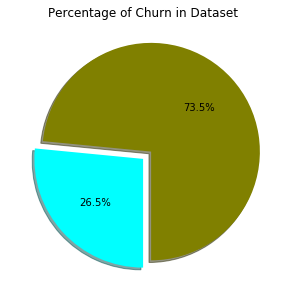

In [3]:
# Data to plot for the % of target variable
labels =df_TCC['Churn'].value_counts(sort = True).index
sizes = df_TCC['Churn'].value_counts(sort = True)
colors = ["olive","aqua"] 
rcParams['figure.figsize'] = 5,5

# Plot
plt.pie(sizes, explode=(0.1, 0), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Churn in Dataset')
plt.show()

In [4]:
df_TCC.duplicated().values.any() #This returns a boolean value indicating that there any duplicates in the dataframe 

False

In [5]:
df_TCC.isnull().values.any() #This returns a boolean value indicating that there any nan values in the dataframe

False

Dropping irrelevant data as it does not influence our predicted outcome

In [6]:
df_TCC.drop(['customerID'], axis=1, inplace=True)

In [7]:
df_TCC.head() # a few columns being SeniorCitizen, tenure, MonthlyCharges and TotalCharges so this might end up being our main variables for the model
df_TCC.shape

(7043, 20)

In [8]:
df_TCC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


In [9]:
type(df_TCC.loc[0][18])

str

Not all values were detected to be float64 type in the 'TotalCharges' column, so there is a possibilty that there are some non- numeric values so we'll remove those samples and set them to numeric

In [10]:
total_charges_filter = df_TCC.TotalCharges == " "
df_TCC = df_TCC[~total_charges_filter]
df_TCC.TotalCharges = pd.to_numeric(df_TCC.TotalCharges)


It seems like ‘TotalCharges’ values were for customers with 0 months tenure. We will adjust these values to 0 and view the unique values in the data thereafter. The next thing after that will be to convert the categorical values into numeric values as well as removing columns that won't be used in the model for predicting.

In [11]:
df_TCC[df_TCC['TotalCharges'].isna()==True] = 0
df_TCC['OnlineBackup'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [12]:
df_TCC['gender'].replace(['Male','Female'],[0,1],inplace=True)
df_TCC['Partner'].replace(['Yes','No'],[1,0],inplace=True)
df_TCC['Dependents'].replace(['Yes','No'],[1,0],inplace=True)
df_TCC['PhoneService'].replace(['Yes','No'],[1,0],inplace=True)
df_TCC['MultipleLines'].replace(['No phone service','No', 'Yes'],[0,0,1],inplace=True)
df_TCC['InternetService'].replace(['No','DSL','Fiber optic'],[0,1,2],inplace=True)
df_TCC['OnlineSecurity'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['OnlineBackup'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['DeviceProtection'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['TechSupport'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['StreamingTV'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['StreamingMovies'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
df_TCC['Contract'].replace(['Month-to-month', 'One year', 'Two year'],[0,1,2],inplace=True)
df_TCC['PaperlessBilling'].replace(['Yes','No'],[1,0],inplace=True)
df_TCC['PaymentMethod'].replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'],[0,1,2,3],inplace=True)
df_TCC['Churn'].replace(['Yes','No'],[1,0],inplace=True)
 

df_TCC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null int64
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
tenure              7032 non-null int64
PhoneService        7032 non-null int64
MultipleLines       7032 non-null int64
InternetService     7032 non-null int64
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
Contract            7032 non-null int64
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null int64
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
dtypes: float64(2), int64(18)
memory usage: 1.1 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f137d3d4e10>,
      dtype=object)

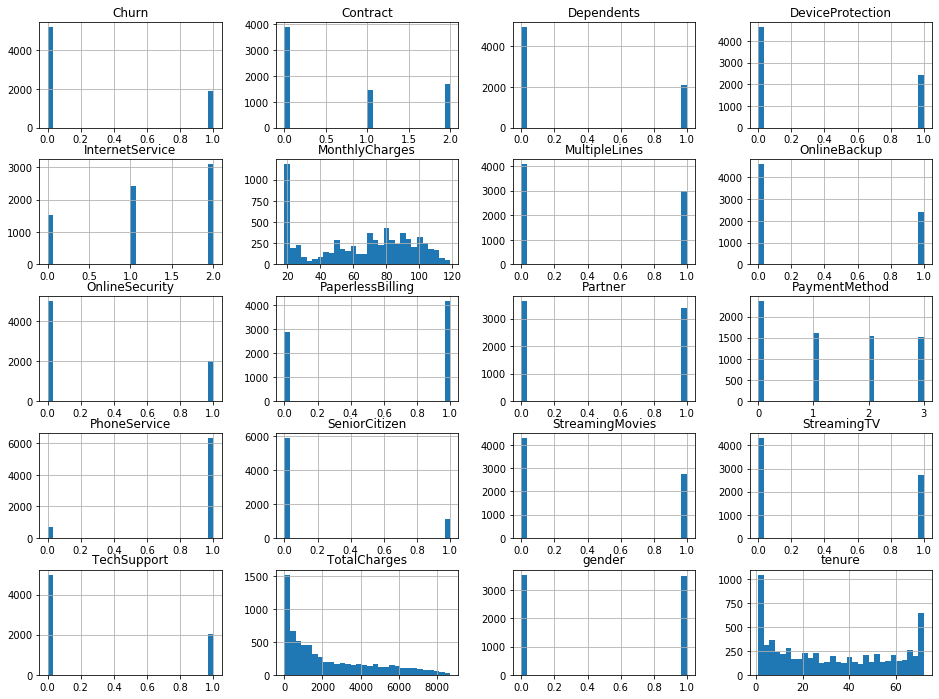

In [13]:
df_TCC.hist(bins=30, figsize=(16, 12))

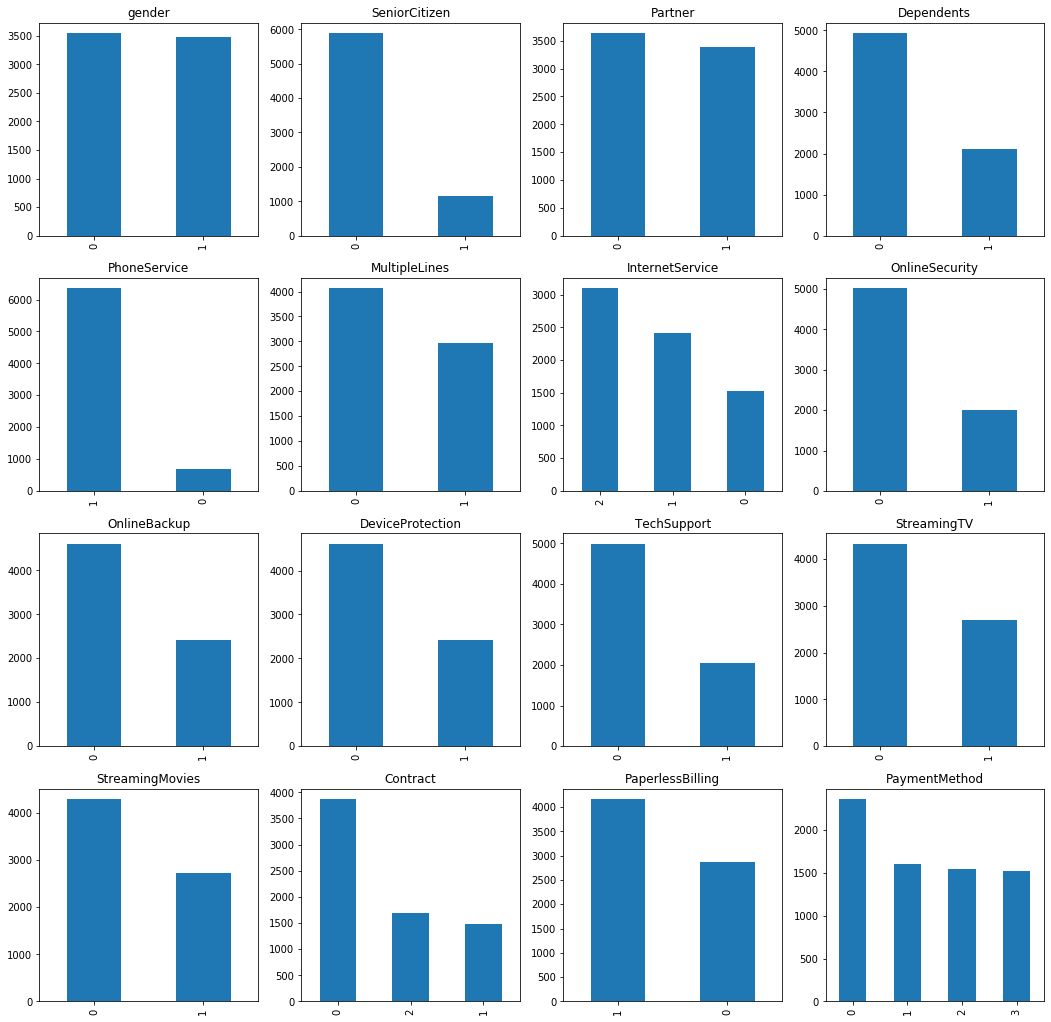

In [14]:
categorical_features = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
]

target = 'Churn'

ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df_TCC[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)

In [15]:
df_TCC.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,0,70.70,151.65,1


So from the short analysis performed above we can see that it has no duplicates nor null values so it is safe to say that we can proceed to the next step

### Train, Test and Split



We are going to split our data using data slicing. While building our model, we are going to make use of the training data set and even through standardization.

In [16]:
X = df_TCC.values[:, 1:21] #Features
Y = df_TCC.values[:,0] #Target variable 'Churn'
len(X), len(Y)

(7032, 7032)

We are building our decision tree classifier but irst separate out the target variables from the rest of our features present in the data.

The above snippet divides data into feature set & target set. The “X ” set consists of predictor variables. It consists of data from 2nd column to 5th column. The “Y” set consists of the outcome variable. It consists of data in the 1st column. We are using “.values” of numpy converting our dataframes into numpy arrays.

And now we are going to split...

In [17]:
df_TCC["Churn"] = df_TCC["Churn"].astype(int)
X = df_TCC.drop(labels = ["Churn"],axis = 1)
y = df_TCC["Churn"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [19]:
model = tree.DecisionTreeClassifier(criterion='gini')
model = model.fit(X_train, y_train)

In [20]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
model.score(X_train, y_train) 

0.9982222222222222

In [22]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

The code above will split data into training and test set. X_train, y_train are training data &  X_test, y_test belongs to the test dataset.

The parameter test_size is given value 0.3; it means test sets will be 30% of whole dataset  & training dataset’s size will be 70% of the entire dataset. random_state variable is a pseudo-random number generator state used for random sampling

In [23]:
X_train.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,0.495111,0.167644,0.484267,0.292800,32.413511,0.904533,0.425956,1.228800,0.282489,0.345067,0.341867,0.289244,0.380089,0.387733,0.689600,0.592356,1.323733,64.880240,2287.014791
std,0.500021,0.373583,0.499797,0.455088,24.545282,0.293885,0.494531,0.777819,0.450250,0.475432,0.474377,0.453452,0.485452,0.487277,0.834238,0.491440,1.150289,30.047992,2268.924335
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,18.800000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.650000,402.500000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.450000,1396.250000
75%,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,90.000000,3782.400000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.650000,8684.800000


In [24]:
X_train.isnull().values.any()

False

In [25]:
df_TCC.corr().style.background_gradient(cmap='Pastel1')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1,0.00181939,0.00137905,-0.0103489,-0.00528537,0.00751498,0.00888274,0.00964271,0.0163278,0.0130928,0.000806746,0.00850716,0.0071244,0.0101054,-9.46992e-05,0.0119019,0.00492753,0.0137793,-4.78395e-05,0.00854464
SeniorCitizen,0.00181939,1,0.0169566,-0.21055,0.0156835,0.00839161,0.142996,0.25903,-0.0385764,0.0666628,0.0595139,-0.0605768,0.105445,0.119842,-0.14182,0.156258,-0.0937124,0.219874,0.102411,0.150541
Partner,0.00137905,0.0169566,1,0.452269,0.381912,0.0183972,0.142561,0.000938123,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,0.294094,-0.0139567,0.13328,0.097825,0.319072,-0.149982
Dependents,-0.0103489,-0.21055,0.452269,1,0.163386,-0.00107781,-0.0243067,-0.177789,0.0807855,0.0236388,0.0138997,0.0630532,-0.0164987,-0.0383749,0.240556,-0.110131,0.124002,-0.112343,0.0646532,-0.163128
tenure,-0.00528537,0.0156835,0.381912,0.163386,1,0.00787733,0.332399,0.0312723,0.328297,0.361138,0.36152,0.325288,0.280264,0.285402,0.676734,0.00482316,0.340939,0.246862,0.82588,-0.354049
PhoneService,0.00751498,0.00839161,0.0183972,-0.00107781,0.00787733,1,0.27953,0.0941822,-0.0916757,-0.0521334,-0.0700756,-0.0951385,-0.0213827,-0.0334775,0.00301869,0.0166961,-0.00310643,0.248033,0.113008,0.0116914
MultipleLines,0.00888274,0.142996,0.142561,-0.0243067,0.332399,0.27953,1,0.345068,0.098592,0.202228,0.201733,0.100421,0.257804,0.259194,0.107529,0.163746,0.0360085,0.490912,0.469042,0.0400327
InternetService,0.00964271,0.25903,0.000938123,-0.177789,0.0312723,0.0941822,0.345068,1,0.156493,0.307223,0.31342,0.164532,0.429616,0.42682,-0.288855,0.377644,-0.178655,0.905389,0.428212,0.31635
OnlineSecurity,0.0163278,-0.0385764,0.143346,0.0807855,0.328297,-0.0916757,0.098592,0.156493,1,0.283285,0.274875,0.354458,0.175514,0.187426,0.24566,-0.00405125,0.162848,0.296447,0.412619,-0.17127
OnlineBackup,0.0130928,0.0666628,0.141849,0.0236388,0.361138,-0.0521334,0.202228,0.307223,0.283285,1,0.303058,0.293705,0.281601,0.274523,0.155262,0.127056,0.0962463,0.441529,0.5101,-0.082307


In [26]:
print(X_train.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


### Factors that predict user churn

- Gender
- SeniorCitizen
- Partner
- Dependents
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod
- MonthlyCharges
- TotalCharges

We happened to use two methods of gettingt the trained decision tree, 1. by using graphviz and 2. by using pydotplus.

Branches represent the actions while the internal nodes represent a decision. Leaf nodes represent the final target variables i.e whether a customer is churning or not (1/0)

In [27]:
import graphviz
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=X_train.columns,  
                     class_names="Churn",  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.format = 'png'
graph.render("data")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.609381 to fit


In [28]:
import pydotplus

feature_cols = ["gender","SeniorCitizen","Partner","Dependents","tenure","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod","MonthlyCharges","TotalCharges"]

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('churn.png')
graph.write_pdf('churn.pdf') #Create pdf
Image(graph.create_png())
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.609381 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.609381 to fit



### Testing the accuracy of our model by making predictions on test data

We are using cross-validation here in order to avoid bias while testing the model for accuracy.

In [29]:
print("The training prediction accuracy is: ", model.score(X_train,y_train)*100,"%")

The training prediction accuracy is:  99.82222222222222 %


In [30]:
from sklearn.model_selection import  cross_val_score
# 10 Folds Cross Validation 
model_score = cross_val_score(model, X_train, y_train, cv=10)
print(model_score)
model_score.mean()

[0.71936057 0.76198934 0.72468917 0.75310835 0.72468917 0.6660746
 0.70870337 0.76868327 0.72905526 0.7486631 ]


0.7305016198923915

In [31]:
print(metrics.accuracy_score(y_test, y_pred))

0.7292110874200426


In [32]:
print(metrics.confusion_matrix(y_test, y_pred))

[[853 193]
 [188 173]]


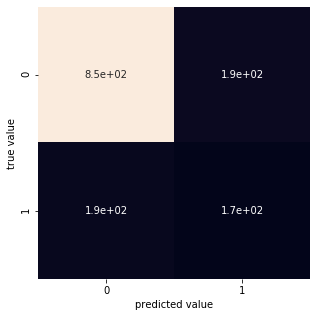

In [33]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

In [34]:
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(model.score(X_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy of decision tree classifier on test set: 1.00
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1046
           1       0.47      0.48      0.48       361

    accuracy                           0.73      1407
   macro avg       0.64      0.65      0.65      1407
weighted avg       0.73      0.73      0.73      1407



The following variables simply represent the True positive, False positive, False negative, True negative and the Total churned and Total Not churned values in the confusion matrix:
A = True Positive
B = False positive
C = False Negative
D = True negative
Tc = Total churned
Tnc = Total not churned

### * Sensitivity:
A/(A + C) × 100
= 833 / (833 + 181) * 100
= 82%

### * Specificity: 
D/(D + B) × 100
= 190 / (190 + 203) * 100
= 48%

### * Churn Prevalence
Tchurned/ Total × 100
= 1014 / 1407 * 100
= 72%

### * Positive Predictive Value: 
A/(A + B) × 100
= 833 / (833 + 203) * 100
= 80%

### * Negative Predictive Value: 
D/(D + C) × 100 
= 190 / (190 + 181) * 100
= 51%

Sensitivity and specificity are inversely proportional, meaning that as the sensitivity increases, the specificity decreases and vice versa. 

Positive and negative predictive values are directly related to the prevalence of the churned in the population. Assuming all other factors remain constant, the PPV will increase with increasing prevalence; and NPV decreases with increase in prevalence

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_curve

### Train, Test and Split

In [36]:
df_TCC["Churn"] = df_TCC["Churn"].astype(int)
X = df_TCC.drop(labels = ["Churn"],axis = 1)
y = df_TCC["Churn"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [38]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

/home/johanna/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
logistic_regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
logistic_regresion = logistic_regression.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic_regression.score(X_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.64
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1042
           1       0.25      0.26      0.26       365

    accuracy                           0.61      1407
   macro avg       0.50      0.50      0.50      1407
weighted avg       0.61      0.61      0.61      1407



In [41]:
print(metrics.confusion_matrix(y_test, y_pred))

[[765 277]
 [271  94]]


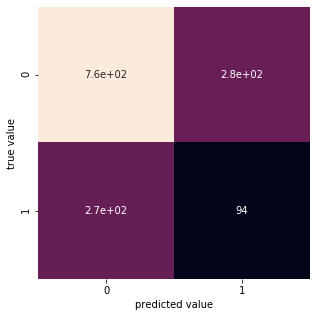

In [42]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');
# 0 = 

The following variables simply represent the True positive, False positive, False negative, True negative and the Total churned and Total Not churned values in the confusion matrix:
A = True Positive
B = False positive
C = False Negative
D = True negative
Tc = Total churned
Tnc = Total not churned

### * Sensitivity(true positive rate):
A/(A + C) × 100
= 825 / (825 + 188) * 100
= 81%

### * Specificity(false positive rate): 
D/(D + B) × 100
= 181 / (181 + 213) * 100
= 46%

### * Churn Prevalence
Tchurned/ Total × 100
= 1013 / 1407 * 100
= 72%

### * Positive Predictive Value: 
A/(A + B) × 100
= 825 / (825 + 213) * 100
= 79%

### * Negative Predictive Value: 
D/(D + C) × 100 
= 181 / (181 + 188) * 100
= 49%

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

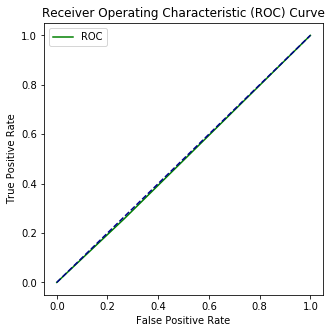

In [44]:
# Defining a python function to plot the ROC curves.
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr, tpr)

#### Intepreting the ROC Curve

From the graph above normally we would expect to see a curve but in this case what was supposed to be a curve is a line exactly just above the base line(dotted line),  which leads us to a conlclusion and indication that it equates to 0.5 for the classifier with the random performance level.

### Overdispersion

Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given statistical model.